### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 6
### Due: Saturday, Mar 14th at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [1]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [1]:
### read in data
import numpy as np

data = np.load('./hw_data/hw6_data_1.npy')
X = data[:, :2]
y = data[:, 2]

print(data)

[[-8.46474567 -3.45517123  1.        ]
 [-9.93233853 -2.31955228  1.        ]
 [-9.30833095 -1.9725388   1.        ]
 ...
 [-3.42236789  1.69166315  2.        ]
 [-3.31992823 -6.1090681   3.        ]
 [-3.62495834  0.11710104  2.        ]]


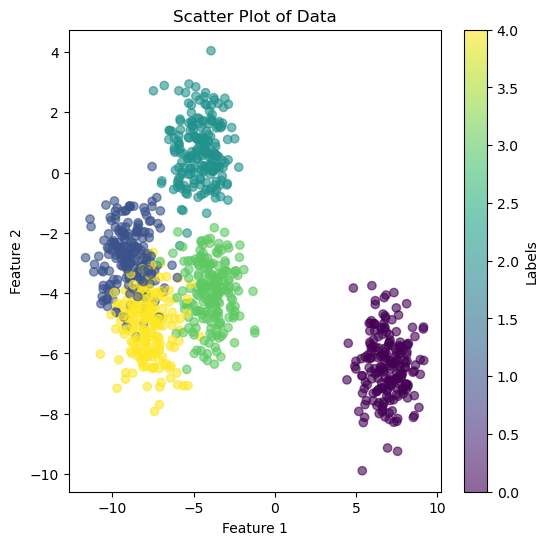

In [5]:
### imports
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

### Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(label="Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Data")
plt.show()

Best bandwidth: 0.4724137931034482


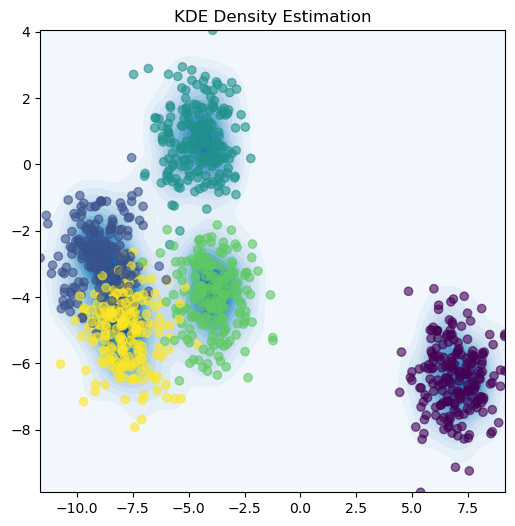

In [9]:
### Kernel Density Estimation using Cross-Validation
params = {'bandwidth': np.linspace(0.1, 1.0, 30)}
kde = KernelDensity()
grid = GridSearchCV(kde, params, cv=5)
grid.fit(X)
best_bandwidth = grid.best_params_['bandwidth']
print(f"Best bandwidth: {best_bandwidth}")


### plot
kde = KernelDensity(bandwidth=best_bandwidth).fit(X)
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()
xgrid, ygrid = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
grid_points = np.vstack([xgrid.ravel(), ygrid.ravel()]).T
log_density = kde.score_samples(grid_points).reshape(100, 100)

plt.figure(figsize=(6, 6))
plt.contourf(xgrid, ygrid, np.exp(log_density), levels=20, cmap='Blues')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title("KDE Density Estimation")
plt.show()

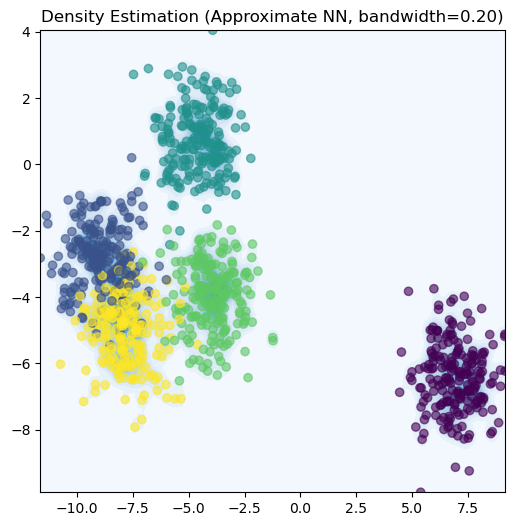

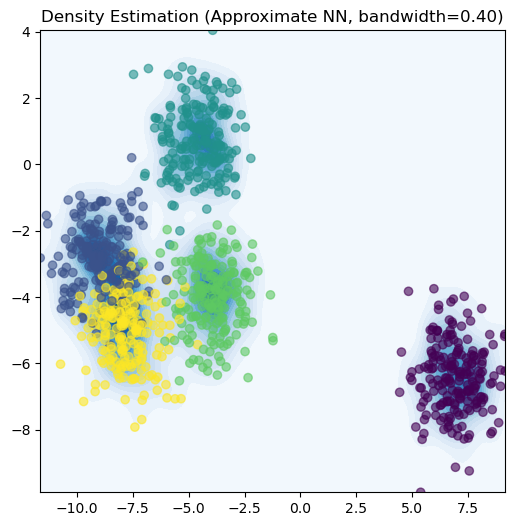

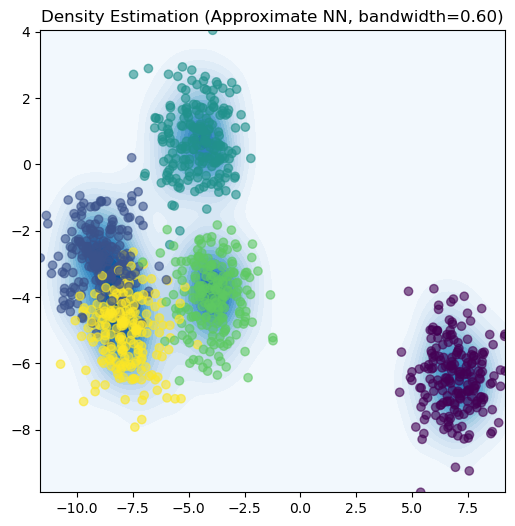

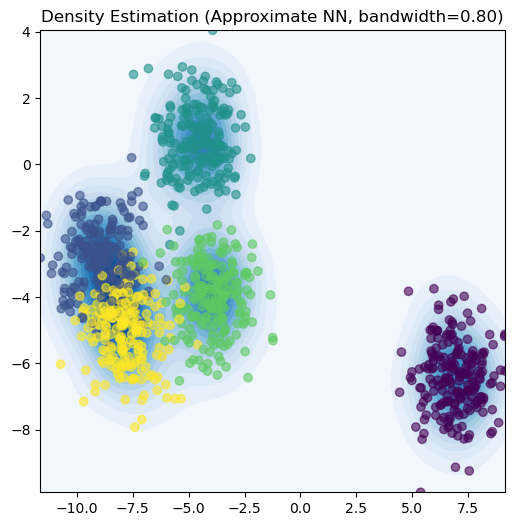

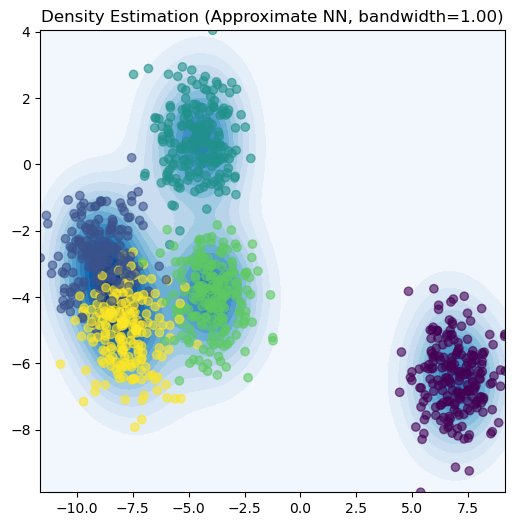

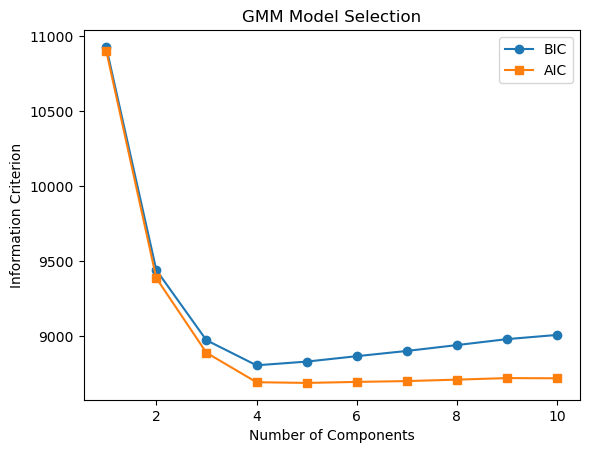

Optimal number of components according to BIC: 4


TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

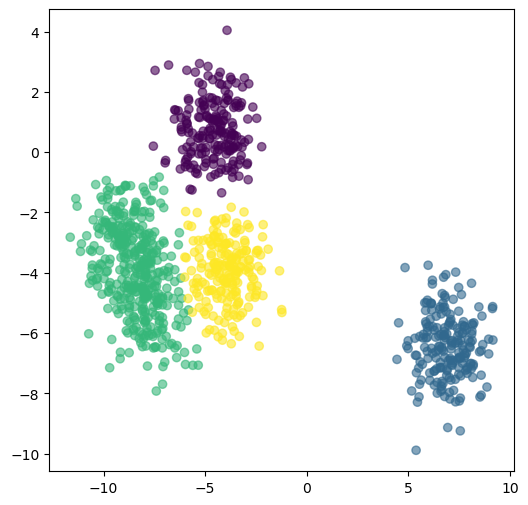

In [27]:
### Nearest Neighbors (Bayesian NN)
k_values = [10, 20, 30, 40, 50]

for k in k_values:
    kde_nn = KernelDensity(kernel='gaussian', bandwidth=k / 50).fit(X)  # Scale k appropriately
    log_density_nn = kde_nn.score_samples(grid_points).reshape(100, 100)

    plt.figure(figsize=(6, 6))
    plt.contourf(xgrid, ygrid, np.exp(log_density_nn), levels=20, cmap='Blues')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
    plt.title(f"Density Estimation (Approximate NN, bandwidth={k/50:.2f})")
    plt.show()

    if k > 50:  # stopping point 50
        break


### Gaussian
bic_values, aic_values = [], []
components_range = range(1, 11)
for n in components_range:
    gmm = GaussianMixture(n_components=n, random_state=42).fit(X)
    bic_values.append(gmm.bic(X))
    aic_values.append(gmm.aic(X))

plt.plot(components_range, bic_values, label='BIC', marker='o')
plt.plot(components_range, aic_values, label='AIC', marker='s')
plt.xlabel("Number of Components")
plt.ylabel("Information Criterion")
plt.legend()
plt.title("GMM Model Selection")
plt.show()

optimal_components = np.argmin(bic_values) + 1
print(f"Optimal number of components according to BIC: {optimal_components}")

gmm = GaussianMixture(n_components=optimal_components, random_state=42).fit(X)
labels = gmm.predict(X)
means = gmm.means_
covariances = gmm.covariances_

def draw_ellipse(mu, C, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    for scale in [1, 2]:
        width, height = 2 * scale * np.sqrt(eigenvalues)
        ellipse = Ellipse(mu, width, height, angle, **kwargs)
        ax.add_patch(ellipse)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
for i in range(optimal_components):
    draw_ellipse(means[i], covariances[i], edgecolor='red', facecolor='none')
plt.scatter(means[:, 0], means[:, 1], c='red', marker='x', s=100)
plt.title("Gaussian Mixture Model Clustering")
plt.show()

# Gaussian part is modified with gpt - kept spitting out different syntax every time...

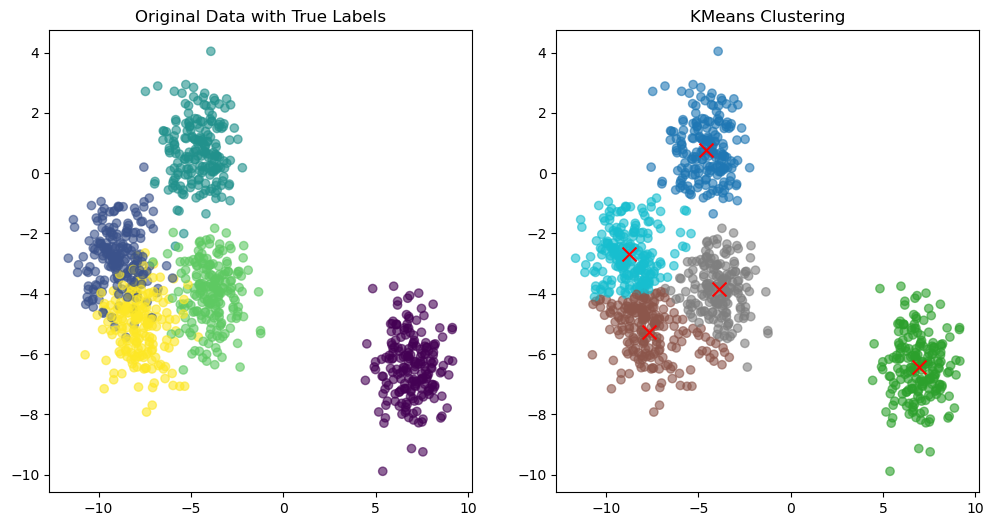

In [29]:
### KMeans Clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
kmeans_labels = kmeans.predict(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
axes[0].set_title("Original Data with True Labels")
axes[1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.6)
axes[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=100)
axes[1].set_title("KMeans Clustering")
plt.show()


<span style="color:red">NP: This seems correct, but given your overplotting of the original data and your clustering results makes it difficult to see your results. -1 pt</span>